# Andrew's model work for Milestone 4, based on David's

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [2]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is the same in both notebooks

# load and clean full dataset?
#load_full = False
load_full = True  # AMG

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
nlp_data_train_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [3]:
processed_data_train_file

'./intermediate_files/processed_data_train.json'

In [4]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [5]:
print len(data)

173805


In [6]:
data_filtered = data[data.loan_term == 36]
data_filtered = data_filtered[pd.to_datetime(data_filtered.issue_date).dt.year.isin([2011,2012,2013])]
print len(data_filtered)

79052


In [7]:
# Get a more manageable sample
np.random.seed(1729)
indexes = np.array(range(len(data_filtered)))
np.random.shuffle(indexes)
print "Indexes computed"                   
data_sampled = data_filtered.iloc[indexes[0:len(indexes)/4], :]
print len(data_sampled)

Indexes computed
19763


In [8]:
data_remaining = data_filtered.iloc[indexes[len(indexes)/4:], :]
print len(data_remaining)

59289


In [9]:
x = data_sampled.drop('loan_status', 1)
y = data_sampled['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

In [10]:
x_test = data_remaining.drop('loan_status', 1)
y_test = data_remaining['loan_status']

In [11]:
y_test.value_counts()

False    50281
True      9008
Name: loan_status, dtype: int64

In [12]:
x.loan_term.value_counts()

36    19763
Name: loan_term, dtype: int64

# Explore and clean up and standardize data

In [13]:
pd.to_datetime(x.issue_date).dt.year.value_counts()

2013    9682
2012    7591
2011    2490
Name: issue_date, dtype: int64

In [14]:
# del x['verif_status']
x.describe().T

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
annual_income,19763.0,6.981315e+04,8.032939e+04,7.200000e+03,4.200000e+04,6.000000e+04,8.400000e+04,7.141778e+06
cpi,19763.0,2.130140e-02,4.214194e-04,2.069612e-02,2.092458e-02,2.132454e-02,2.166718e-02,2.224093e-02
delinq_2_yrs,19763.0,1.867631e-01,4.847464e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
desc_len,9697.0,2.497785e+02,2.121872e+02,1.000000e+00,NaN,NaN,NaN,4.544000e+03
dti,19763.0,2.418883e-03,1.133840e-03,0.000000e+00,1.555584e-03,2.375341e-03,3.241890e-03,5.386393e-03
gdp,19763.0,9.997263e-01,3.296536e-05,9.996063e-01,9.997035e-01,9.997311e-01,9.997524e-01,9.997853e-01
id,19763.0,3.602569e+06,2.742526e+06,3.646930e+05,1.338386e+06,2.375759e+06,5.844894e+06,1.022466e+07
inquiry_6_mos,19763.0,7.960836e-01,9.562914e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
installment,19763.0,3.989107e+02,2.462650e+02,3.042000e+01,2.191400e+02,3.433900e+02,5.146400e+02,1.408130e+03
interest_rate,19763.0,1.282315e+01,3.996400e+00,5.420000e+00,9.910000e+00,1.299000e+01,1.561000e+01,2.589000e+01


In [15]:
# earliest_credit is not really a good indicator -- we want to know how long has elapsed since then
# See http://stackoverflow.com/questions/17414130/pandas-datetime-calculate-number-of-weeks-between-dates-in-two-columns
x['months_since_earliest_credit'] = (
    (pd.to_datetime(x.issue_date) - pd.to_datetime(x.earliest_credit))/np.timedelta64(1,'M')
).round()
x_test['months_since_earliest_credit'] = (
    (pd.to_datetime(x_test.issue_date) - pd.to_datetime(x_test.earliest_credit))/np.timedelta64(1,'M')
).round()

In [16]:
x.columns

Index([               u'address_state',                u'annual_income',
                                u'cpi',                 u'delinq_2_yrs',
                           u'desc_len',                  u'description',
                                u'dti',              u'earliest_credit',
                      u'employ_length',                 u'employ_title',
                                u'gdp',                   u'home_owner',
                                 u'id',          u'initial_list_status',
                      u'inquiry_6_mos',                  u'installment',
                      u'interest_rate',                          u'ipr',
                         u'issue_date',                  u'loan_amount',
                       u'loan_purpose',                u'loan_subgrade',
                          u'loan_term',     u'months_since_last_record',
                      u'open_accounts',                   u'recoveries',
                         u'revol_util',            

In [17]:
def expand_x(x, x_orig):
    x_expanded = pd.DataFrame()
    for colname in x_orig.columns:
        if colname in ('description', 'verif_status', 'loan_subgrade', 'id', 'interest_rate', 
                       'loan_term',
                       'index', 'recoveries', 'issue_date', 'earliest_credit'):
            continue
        print colname, x_orig[colname].dtype
        if x_orig[colname].dtype == 'object':
            values = x[colname].fillna('MISSING')
            value_columns = x_orig[colname].fillna('MISSING').value_counts().index
            if len(value_columns) > 50:
                value_columns = value_columns[:50]
            for val in value_columns:
                x_expanded[colname + '__' + val.replace(' ', '_')] = (values == val).astype(int)
        else:
            values = x[colname].fillna(x[colname].median())
            sd = np.nanstd(x_orig[colname])
            if sd < 1e-10:
                sd = 1
            x_expanded[colname] = (values - np.nanmean(x_orig[colname]))/sd
    return x_expanded

In [18]:
x_expanded = expand_x(x, x)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
ipr float64
loan_amount int64
loan_purpose object
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64


In [19]:
x_expanded.describe().T

,count,mean,std,min,25%,50%,75%,max
address_state__CA,19763.0,1.766432e-01,0.381376,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NY,19763.0,8.844811e-02,0.283953,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__TX,19763.0,7.665840e-02,0.266055,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__FL,19763.0,7.311643e-02,0.260334,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__IL,19763.0,3.951829e-02,0.194829,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NJ,19763.0,3.678591e-02,0.188241,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__PA,19763.0,3.111876e-02,0.173643,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__OH,19763.0,3.096696e-02,0.173233,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__GA,19763.0,3.056216e-02,0.172133,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__VA,19763.0,3.015736e-02,0.171024,0.000000,0.000000,0.000000,0.000000,1.000000


In [20]:
x_expanded.columns

Index([             u'address_state__CA',              u'address_state__NY',
                    u'address_state__TX',              u'address_state__FL',
                    u'address_state__IL',              u'address_state__NJ',
                    u'address_state__PA',              u'address_state__OH',
                    u'address_state__GA',              u'address_state__VA',
       ...
               u'loan_purpose__vacation',            u'loan_purpose__house',
       u'loan_purpose__renewable_energy',       u'months_since_last_record',
                        u'open_accounts',                     u'revol_util',
                                  u'rir',                 u'total_accounts',
                             u'unemploy',   u'months_since_earliest_credit'],
      dtype='object', length=145)

In [21]:
x_test_expanded = expand_x(x_test, x)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
ipr float64
loan_amount int64
loan_purpose object
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64


In [22]:
# be prepared to split stuff up by year of issue
years = pd.to_datetime(x.issue_date).dt.year

In [23]:
years_test = pd.to_datetime(x_test.issue_date).dt.year

# Start evaluating models

In [24]:
#for yr in set(years.values):
#    rf = RFC(random_state=1729,
#             max_depth=5,
#             n_estimators=100,
#             oob_score=True
#            ).fit(x_expanded[years==yr], y[years==yr])
#    print "%d  oob score: %.3f  baseline: %.3f" % (yr, rf.oob_score_, 1-y[years==yr].mean(),)

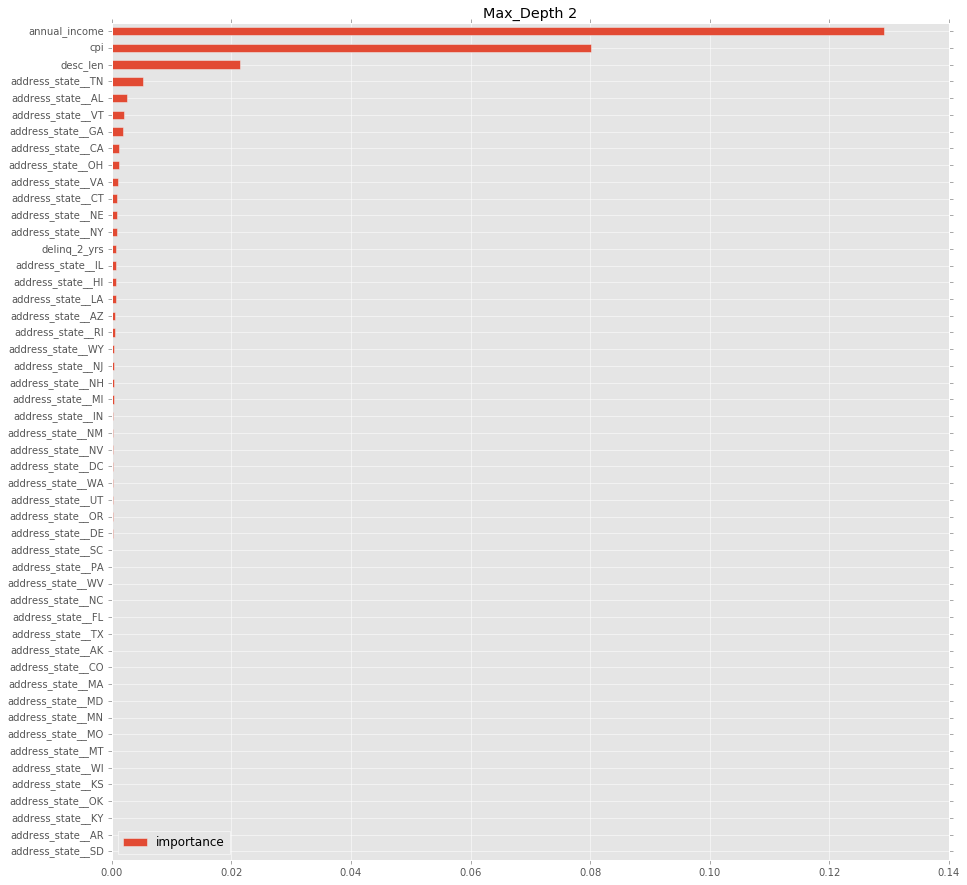

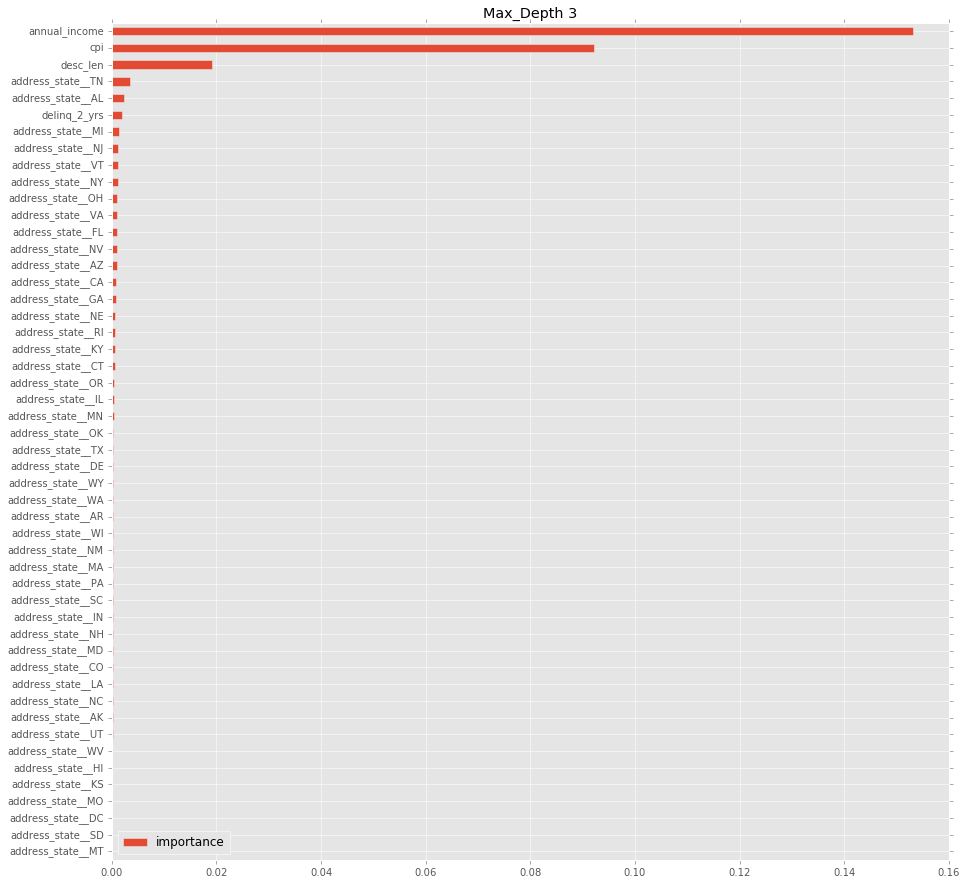

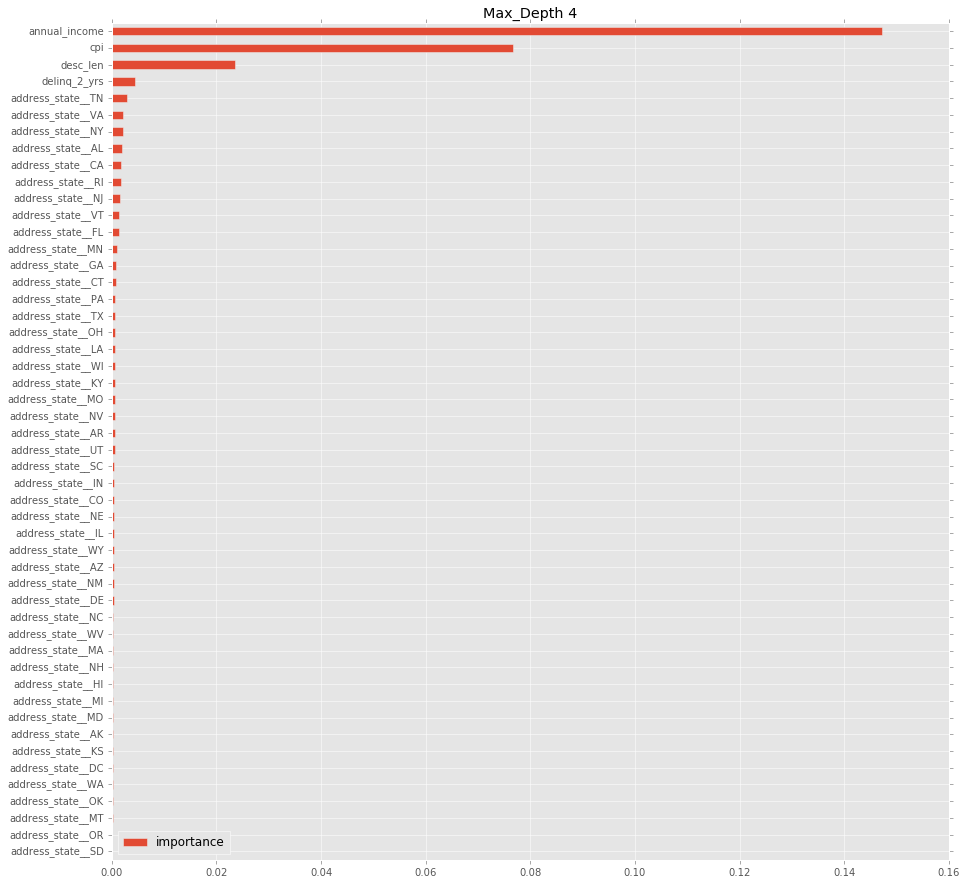

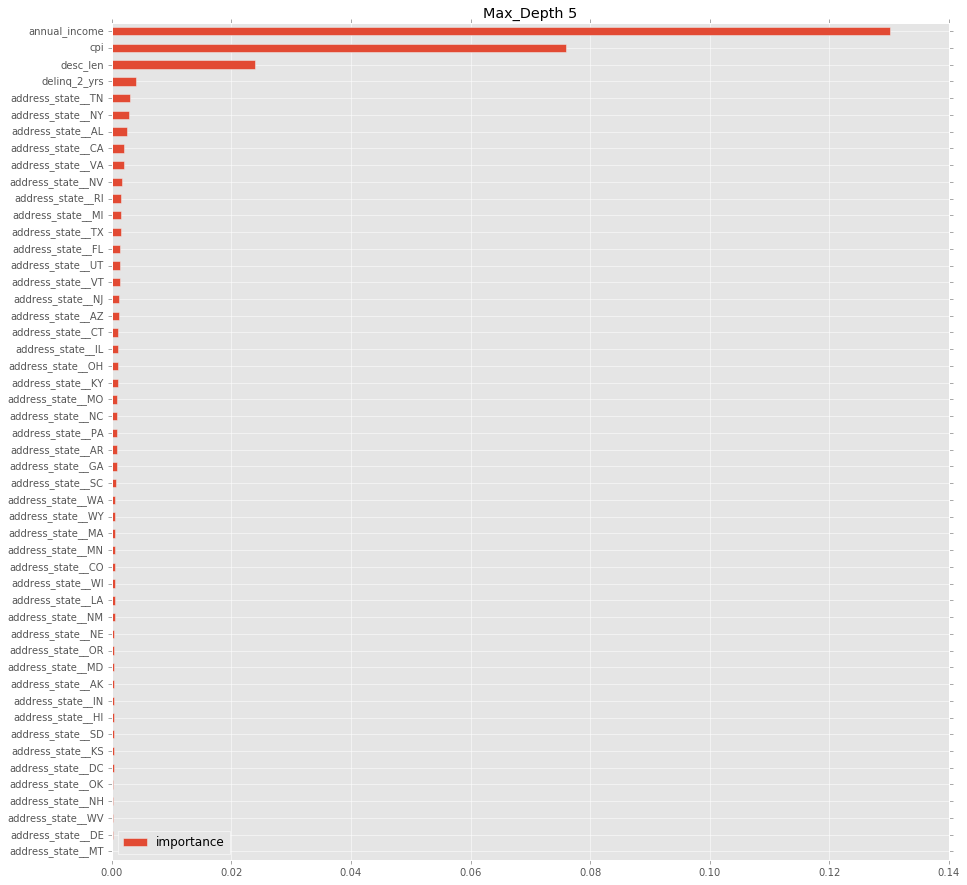

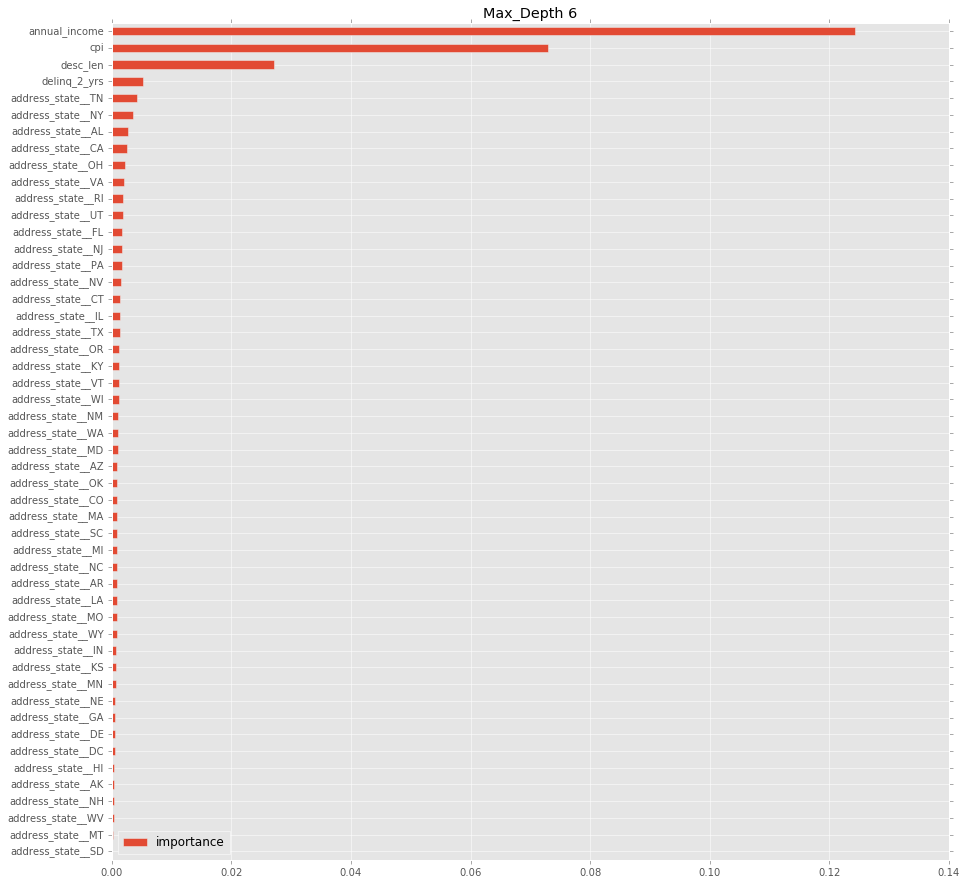

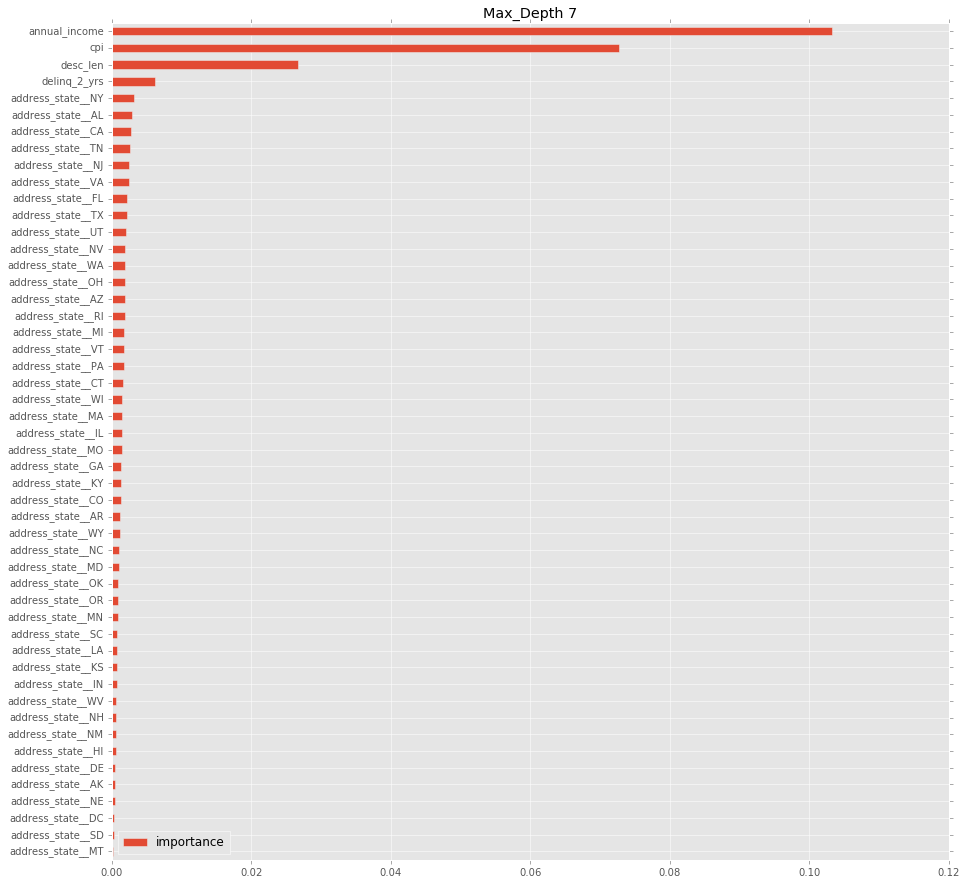

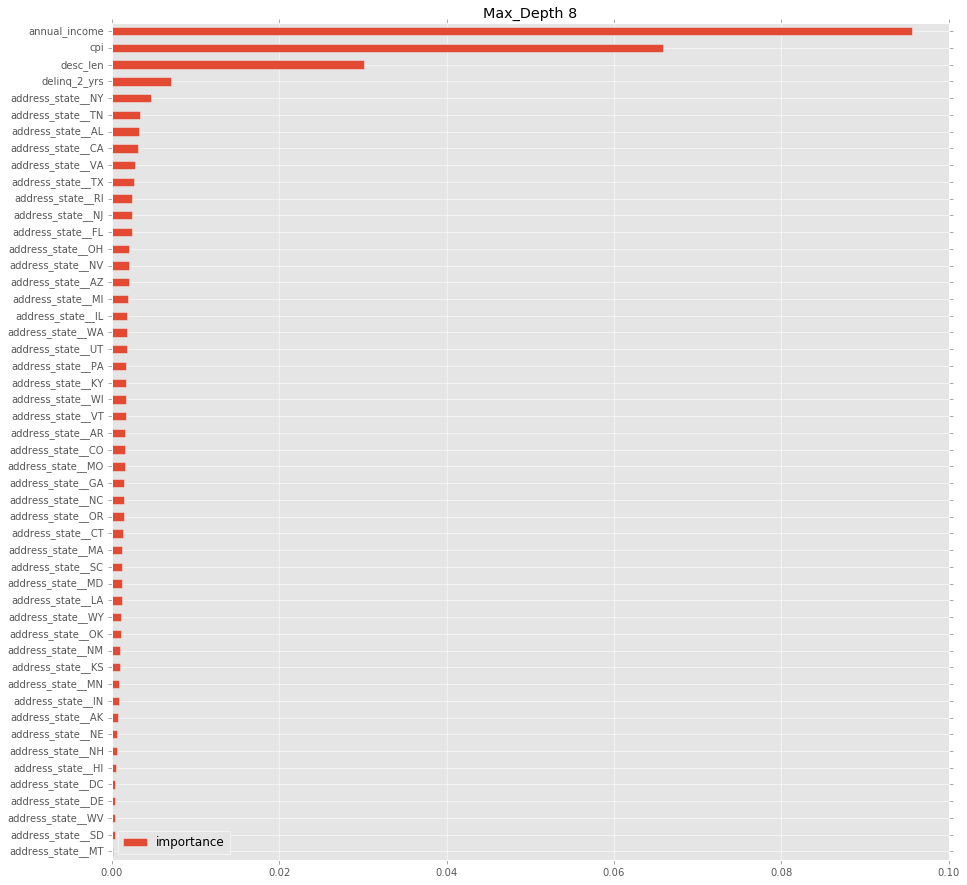

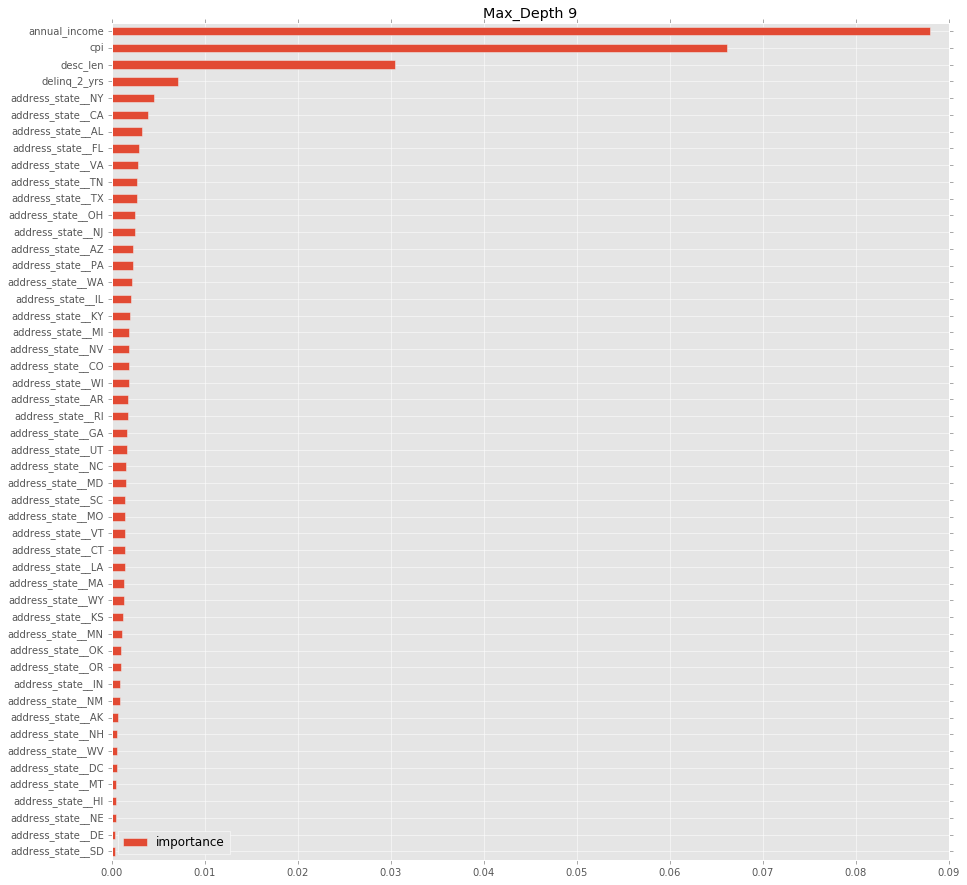

In [25]:
# One RF with all years combined; what predictors matter?
for md in range(2,10):
    yrs_in_2011_2013 = years.isin([2011, 2012, 2013])
    rf = RFC(random_state=1729,
         max_depth=md,
         n_estimators=300,
         oob_score=True
        ).fit(x_expanded[yrs_in_2011_2013], y[yrs_in_2011_2013])
    plt.figure(figsize=(15,15))
    pd.DataFrame(rf.feature_importances_, 
             index=x_expanded.columns,
             columns=['importance'],
             ).iloc[0:50,:].sort_values(by='importance',
                           ascending=True,
             ).plot(kind='barh', ax=plt.gca())
    plt.title("Max_Depth " + str(md))
    plt.show()

In [26]:
def eval_model_all_years(model_factory, columns=None, prob_threshold=0.5):
    k = 5
    np.random.seed(1729)
    
    if columns is None:
        x_local = x_expanded
        x_local_test = x_test_expanded
    else:
        x_local = x_expanded[columns]
        x_local_test = x_test_expanded[columns]
        
    if True: # for yr in [2011, 2012, 2013]: # set(years.values):
        indexes = range(len(years))
        np.random.shuffle(indexes)

        cm_accum = np.zeros((2, 2))
        f1_accum = 0
        score = 0
        weighted_score = 0

        # k-fold cross-validation
        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            #print "TRAIN ", train_indexes
            #print 'TEST', test_indexes
            #print "Y", y.iloc[test_indexes]
            
            # model = model_factory().fit(x_expanded[years==yr], y[years==yr])
            # score = model.score(x_expanded[years==yr], y[years==yr]) / k
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            yhat = model.predict(x_local)
            score += model.score(x_local.iloc[test_indexes], y.iloc[test_indexes]) / k
            yhat_weighted = (model.predict_proba(x_local)[:,0] > prob_threshold)[test_indexes]
            weighted_score += (y.iloc[test_indexes][yhat_weighted]).mean() / k
            cm_accum += confusion_matrix(y.iloc[test_indexes], yhat[test_indexes])
            f1_accum += f1_score(y.iloc[test_indexes], yhat[test_indexes], pos_label = 1) / k
        
        # but also test against the x_test
        test_yhat = (model.predict_proba(x_local_test)[:,0] > prob_threshold)
        test_score = (y_test == test_yhat).mean()
        test_precision = 1- y_test[test_yhat].mean()
        test_f1 = f1_score(y_test, test_yhat, pos_label = 1)

        print "%d  score: %.3f  baseline: %.3f   wscore: %.3f   f1: %.3f  | test score %.3f  1-prec %.3f f1 %.3f"  % (
            0, score, 1-y.mean(), 1-weighted_score, f1_accum, test_score, test_precision, test_f1)

# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

In [27]:
def eval_model_by_year(model_factory, columns=None, prob_threshold=0.5):
    eval_model_all_years(model_factory, columns, prob_threshold)
    k = 5
    np.random.seed(1729)
    
    if columns is None:
        x_local = x_expanded
        x_local_test = x_test_expanded
    else:
        x_local = x_expanded[columns]
        x_local_test = x_test_expanded[columns]
        
    for yr in [2011, 2012, 2013]: # set(years.values):
        indexes = np.where(years==yr)[0]
        np.random.shuffle(indexes)

        cm_accum = np.zeros((2, 2))
        f1_accum = 0
        score = 0
        weighted_score = 0

        # k-fold cross-validation
        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            #print "TRAIN ", train_indexes
            #print 'TEST', test_indexes
            #print "Y", y.iloc[test_indexes]
            
            # model = model_factory().fit(x_expanded[years==yr], y[years==yr])
            # score = model.score(x_expanded[years==yr], y[years==yr]) / k
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            yhat = model.predict(x_local)
            score += model.score(x_local.iloc[test_indexes], y.iloc[test_indexes]) / k
            yhat_weighted = (model.predict_proba(x_local)[:,0] > prob_threshold)[test_indexes]
            weighted_score += (y.iloc[test_indexes][yhat_weighted]).mean() / k
            cm_accum += confusion_matrix(y.iloc[test_indexes], yhat[test_indexes])
            f1_accum += f1_score(y.iloc[test_indexes], yhat[test_indexes], pos_label = 1) / k
        
        # but also test against the x_test
        test_score = model.score(x_local_test[years_test == yr], y_test[years_test == yr])
        test_yhat = (model.predict_proba(x_local_test[years_test == yr])[:,0] > prob_threshold)
        test_precision = 1- y_test[years_test == yr][test_yhat].mean()

        print "%d  score: %.3f  baseline: %.3f   wscore: %.3f   f1: %.3f  | test score %.3f  1-prec %.3f"  % (
            yr, score, 1-y[years==yr].mean(), 1-weighted_score, f1_accum, test_score, test_precision)

# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

In [28]:
eval_model_by_year(lambda: Log_Reg())

0  score: 0.845  baseline: 0.846   wscore: 0.848   f1: 0.029  | test score 0.152  1-prec 0.849 f1 0.262


C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2011  score: 0.893  baseline: 0.895   wscore: 0.896   f1: 0.016  | test score 0.892  1-prec 0.893
2012  score: 0.863  baseline: 0.863   wscore: 0.863   f1: 0.009  | test score 0.864  1-prec 0.865
2013  score: 0.819  baseline: 0.821   wscore: 0.825   f1: 0.064  | test score 0.823  1-prec 0.827


In [29]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'))

0  score: 0.630  baseline: 0.846   wscore: 0.903   f1: 0.342  | test score 0.378  1-prec 0.902 f1 0.155
2011  score: 0.628  baseline: 0.895   wscore: 0.915   f1: 0.214  | test score 0.635  1-prec 0.923
2012  score: 0.618  baseline: 0.863   wscore: 0.901   f1: 0.290  | test score 0.614  1-prec 0.904
2013  score: 0.634  baseline: 0.821   wscore: 0.884   f1: 0.377  | test score 0.634  1-prec 0.890


In [30]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6)

0  score: 0.630  baseline: 0.846   wscore: 0.926   f1: 0.342  | test score 0.539  1-prec 0.923 f1 0.109
2011  score: 0.628  baseline: 0.895   wscore: 0.925   f1: 0.214  | test score 0.635  1-prec 0.933
2012  score: 0.618  baseline: 0.863   wscore: 0.924   f1: 0.290  | test score 0.614  1-prec 0.922
2013  score: 0.634  baseline: 0.821   wscore: 0.909   f1: 0.377  | test score 0.634  1-prec 0.911


In [31]:
eval_model_by_year(lambda: QDA())

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0  score: 0.169  baseline: 0.846   wscore: 0.893   f1: 0.267  | test score 0.835  1-prec 0.862 f1 0.030
2011  score: 0.160  baseline: 0.895   wscore: 0.878   f1: 0.185  | test score 0.154  1-prec 0.907
2012  score: 0.156  baseline: 0.863   wscore: 0.889   f1: 0.242  | test score 0.154  1-prec 0.884
2013  score: 0.194  baseline: 0.821   wscore: 0.868   f1: 0.304  | test score 0.185  1-prec 0.851


In [32]:
# This takes a very long time for practically no uplift
eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

0  score: 0.621  baseline: 0.846   wscore: 0.847   f1: 0.342  | test score 0.152  1-prec 0.849 f1 0.263


In [33]:
# This takes a very long time for practically no uplift
eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

0  score: 0.621  baseline: 0.846   wscore: 0.906   f1: 0.342  | test score 0.397  1-prec 0.904 f1 0.151


In [34]:
# TODO: Try again, this time fitting a regression against the payments received

In [35]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2011   n=2490   d= 261   p: 0.105 | 0.105 | 0.105
y=2012   n=7591   d=1042   p: 0.137 | 0.137 | 0.137
y=2013   n=9682   d=1735   p: 0.179 | 0.179 | 0.179


In [36]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.153721600972
0.239361702128


In [37]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'])

0  score: 0.836  baseline: 0.846   wscore: 0.848   f1: 0.053  | test score 0.162  1-prec 0.850 f1 0.260
2011  score: 0.869  baseline: 0.895   wscore: 0.897   f1: 0.073  | test score 0.871  1-prec 0.896
2012  score: 0.848  baseline: 0.863   wscore: 0.864   f1: 0.051  | test score 0.851  1-prec 0.867
2013  score: 0.819  baseline: 0.821   wscore: 0.824   f1: 0.050  | test score 0.820  1-prec 0.825


In [38]:
eval_model_by_year(lambda: RFC(
        random_state=1729,
        max_depth=5,
        n_estimators=300
        )
)

0  score: 0.846  baseline: 0.846   wscore: 0.846   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.264
2011  score: 0.895  baseline: 0.895   wscore: 0.895   f1: 0.000  | test score 0.893  1-prec 0.893
2012  score: 0.863  baseline: 0.863   wscore: 0.863   f1: 0.000  | test score 0.865  1-prec 0.865
2013  score: 0.821  baseline: 0.821   wscore: 0.821   f1: 0.000  | test score 0.824  1-prec 0.824


In [39]:
eval_model_by_year(lambda: RFC(
        random_state=1729,
        max_depth=5,
        n_estimators=300
        ),
        prob_threshold=0.85
)

0  score: 0.846  baseline: 0.846   wscore: 0.904   f1: 0.000  | test score 0.433  1-prec 0.901 f1 0.153
2011  score: 0.895  baseline: 0.895   wscore: 0.902   f1: 0.000  | test score 0.893  1-prec 0.902
2012  score: 0.863  baseline: 0.863   wscore: 0.889   f1: 0.000  | test score 0.865  1-prec 0.889
2013  score: 0.821  baseline: 0.821   wscore: 0.909   f1: 0.000  | test score 0.824  1-prec 0.915


In [40]:
# TODO: try different depths

In [41]:
from sklearn.dummy import DummyClassifier
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0))

0  score: 0.846  baseline: 0.846   wscore: 0.846   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.264
2011  score: 0.895  baseline: 0.895   wscore: 0.895   f1: 0.000  | test score 0.893  1-prec 0.893
2012  score: 0.863  baseline: 0.863   wscore: 0.863   f1: 0.000  | test score 0.865  1-prec 0.865
2013  score: 0.821  baseline: 0.821   wscore: 0.821   f1: 0.000  | test score 0.824  1-prec 0.824


In [42]:
from sklearn import ensemble
eval_model_by_year(lambda: ensemble.AdaBoostClassifier(random_state=1729))

0  score: 0.845  baseline: 0.846   wscore: 0.848   f1: 0.027  | test score 0.153  1-prec 0.849 f1 0.261
2011  score: 0.889  baseline: 0.895   wscore: 0.898   f1: 0.066  | test score 0.887  1-prec 0.894
2012  score: 0.860  baseline: 0.863   wscore: 0.863   f1: 0.014  | test score 0.863  1-prec 0.865
2013  score: 0.818  baseline: 0.821   wscore: 0.825   f1: 0.072  | test score 0.820  1-prec 0.828


In [43]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [44]:
lr_coeff.sort_values('abs', ascending=False).coeff

loan_amount                           -2.693673
installment                            2.509829
employ_title__USAF                    -1.962124
employ_title__Kaiser_Permanente       -1.727355
employ_title__IBM                     -1.614069
employ_title__The_Home_Depot          -1.336803
employ_title__Lockheed_Martin         -1.286803
employ_title__Time_Warner_Cable       -1.250608
employ_title__BB&T                    -1.250289
employ_title__Account_Manager         -1.231626
employ_title__Morgan_Stanley          -1.092767
employ_title__U.S._Army               -0.984669
employ_title__Fifth_Third_Bank         0.913311
employ_title__Registered_Nurse        -0.855114
employ_title__walmart                 -0.829483
employ_title__State_of_California     -0.803417
address_state__NE                      0.698486
address_state__DE                     -0.684198
address_state__IN                     -0.626192
employ_title__Home_Depot               0.625699
address_state__RI                      0

In [45]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

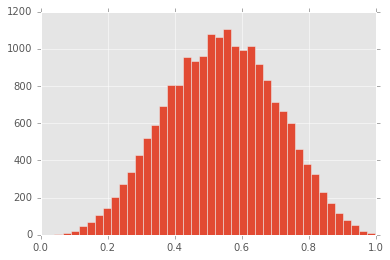

In [46]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [47]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.00    0.000000
0.05    0.444444
0.10    0.569892
0.15    0.599119
0.20    0.630045
0.25    0.684280
0.30    0.720354
0.35    0.754045
0.40    0.791077
0.45    0.835589
0.50    0.857589
0.55    0.867882
0.60    0.909002
0.65    0.929692
0.70    0.934828
0.75    0.951245
0.80    0.975806
0.85    0.966049
0.90    0.986111
0.95    1.000000
Name: loan_status, dtype: float64

In [48]:
def eval_model_with_threshold(model_factory, columns=None):
    k = 5
    np.random.seed(1729)
    if columns is None:
        x_local = x_expanded
    else:
        x_local = x_expanded[columns]

    if True: # because old indent for loop
        indexes = range(len(y))
        np.random.shuffle(indexes)

        probs = np.ones_like(y) * -1

        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            probs_test = (model.predict_proba(x_local)[:,0]) #[test_indexes]
            probs = np.where([ii in test_indexes for ii in range(len(y))],  # slow but the only one I've found that works!
                             probs_test, probs)
            # print i, (probs == -1).sum(), (probs > 0).sum()
            
    thresholds = np.arange(0, 1, 0.05)
    plt.plot(thresholds,
             [1-y[probs > t].mean() for t in thresholds])
    plt.show()

    return probs

In [49]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [50]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [51]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

In [52]:
data_nlp.columns

Index([u'address_state', u'annual_income', u'cpi', u'delinq_2_yrs',
       u'desc_len', u'desc_matrix_reduce', u'desc_word_count', u'description',
       u'dti', u'earliest_credit', u'employ_length', u'employ_title', u'gdp',
       u'home_owner', u'id', u'initial_list_status', u'inquiry_6_mos',
       u'installment', u'interest_rate', u'ipr', u'issue_date', u'loan_amount',
       u'loan_purpose', u'loan_status', u'loan_subgrade', u'loan_term',
       u'misspell_count', u'misspell_count_norm', u'months_since_last_record',
       u'open_accounts', u'recoveries', u'revol_util', u'rir',
       u'total_accounts', u'unemploy', u'verif_status', u'vocab_count',
       u'vocab_count_norm'],
      dtype='object')

In [53]:
# TODO: Polynonmial. AdaBoost. NLP.